# Neeraj Bhatt, Nirmesh Gollamandala
## ANLY 520-51-B

In [71]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [9]:
#pip install contractions

In [37]:
spi = pd.read_csv('spi_nourl.csv')

In [38]:
spi.shape

(903604, 7)

In [39]:
spi.head()

,conversation_id,message_line,author,time,chat_message,author_id,sexual_predator
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,Hola.,0,0
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi.,0,0
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up?,0,0
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton.,0,0
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you?,0,0


In [40]:
sp = spi[spi['sexual_predator'] == 1]
f"There are {sp['author'].nunique()} sexual predators"

'There are 142 sexual predators'

In [41]:
f"There are a total of {spi['conversation_id'].nunique()} conversations"

'There are a total of 66927 conversations'

In [42]:
f"There are a total of {spi['author'].nunique()} users"

'There are a total of 97689 users'

In [43]:
#nltk.download('stopwords')

In [44]:
# generating word frequencies
def gen_freq(text):
    # list of words
    word_list = []
    
    # loop over all the text docs and extract words into word_list
    for words in text.split():
        word_list.extend(words)
        
    # create word freuencies using word_list
    word_freq = pd.Series(word_list).value_counts()
    
    return word_freq

word_freq_normal = gen_freq(spi[spi['sexual_predator'] == 0]['chat_message'].str)
word_freq_predator = gen_freq(spi[spi['sexual_predator'] == 1]['chat_message'].str)
stop_words = stopwords.words('english')

We see a lot of words that are part of normal chat conversations such as like. However, we also see a lot of stopwords as capitalized stopwords are not part of the stop_words nltk has.

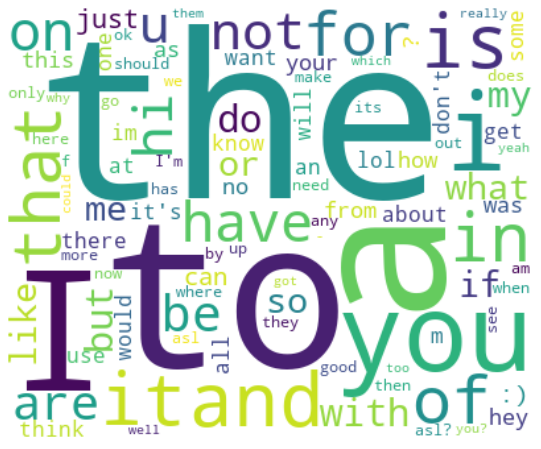

In [45]:
wc_normal = WordCloud(width = 400, height = 330, max_words = 100, 
                      background_color = 'white', stopwords = stop_words).generate_from_frequencies(word_freq_normal)

plt.figure(figsize = (12, 8))
plt.imshow(wc_normal, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [46]:
'I' in stop_words

False

Wordclouds of sexual predators

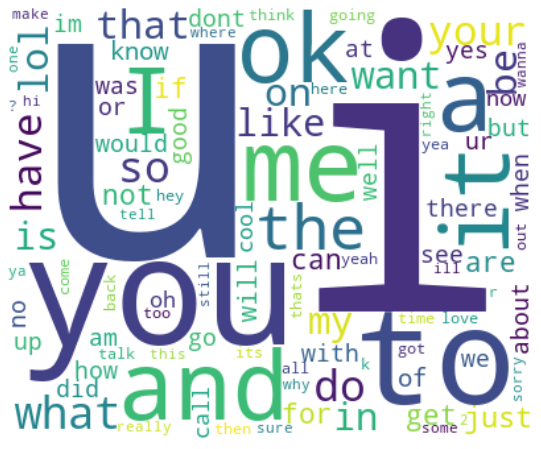

In [47]:
wc_predator = WordCloud(width = 400, height = 330, max_words = 100, 
                        background_color = 'white', stopwords = stop_words).generate_from_frequencies(word_freq_predator)

plt.figure(figsize = (12, 8))
plt.imshow(wc_predator, interpolation = 'bilinear')
plt.axis('off')
plt.show()

The most frequent words for the predators are highly similar for both normal users and sexual predators as expected.

Cleaning the text files and removing stopwords could give us better results. Also since many of the conversations contain jyst the stop words for example whats up? After we appl stemming whats will become what and thus both of them will be removed. So we will filter conversations with atleast 2 words.

Instead of using regular stopwords we will be using smart stopwords that contain general words of conversations.

In [48]:
# getting the smart stopwords
smart_stopwords = open('STOPWORDS.txt')
smart_stopwords = smart_stopwords.readlines()
smart_stopwords = [str.rstrip(word) for word in smart_stopwords]

In [49]:
print(f'Length of regular stopwords is {len(stop_words)}')

Length of regular stopwords is 179


In [50]:
print(f'Length of smart stopwords id {len(smart_stopwords)}')

Length of smart stopwords id 571


In [51]:
ps = PorterStemmer()
pattern = r"[$&+,:;=_?@#|\[\]{}'<>.^*()%!-]"
def clean_text(text):
    text = ' '.join(re.sub(pattern, '', text).strip().split()) # remove punctuations
    text = ' '.join([word for word in text.split() if word.isalpha()]) # only words
    #text = BeautifulSoup(text).get_text() #html
    text = text.lower() #lower case
    text = contractions.fix(text) #contractions
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') #symbols
    text = ' '.join(word for word in text.split() if word not in smart_stopwords) # stopwords
    text = ' '.join([ps.stem(word) for word in text.split()]) #stem
    return text

In [52]:
spi['chat_message'] = spi['chat_message'].apply(lambda x: clean_text(x))
spi.head()

,conversation_id,message_line,author,time,chat_message,author_id,sexual_predator
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,hola,0,0
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,,0,0
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,,0,0
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,ton,0,0
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,,0,0


As expected some conversations with just the stop words have zero words now.

Filtering out conversations with atleast two words

In [53]:
spi_sub = spi[spi['chat_message'].apply(lambda x: len(x.split()) > 1)]
spi_sub.index = range(0, spi_sub.shape[0])

In [54]:
spi_sub.shape

(412898, 7)

Recreating the wordclouds

Normal users

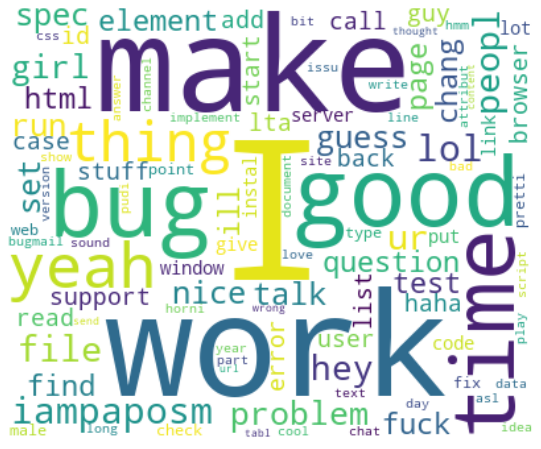

In [55]:
word_freq_normal = gen_freq(spi_sub[spi_sub['sexual_predator'] == 0]['chat_message'].str)
word_freq_predator = gen_freq(spi_sub[spi_sub['sexual_predator'] == 1]['chat_message'].str)

wc_normal = WordCloud(width = 400, height = 330, max_words = 100, 
                      background_color = 'white').generate_from_frequencies(word_freq_normal)

plt.figure(figsize = (12, 8))
plt.imshow(wc_normal, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Sexual Predator

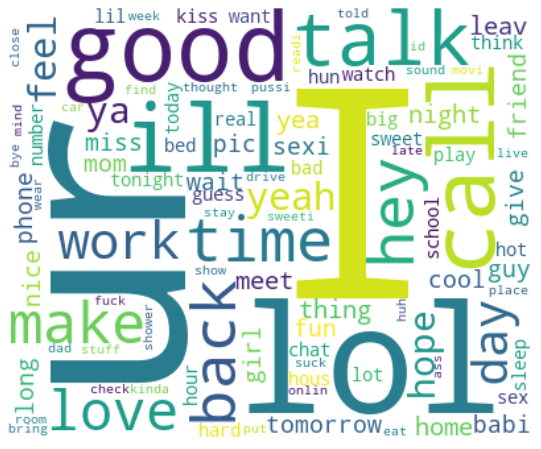

In [56]:
wc_predator = WordCloud(width = 400, height = 330, max_words = 100, 
                      background_color = 'white').generate_from_frequencies(word_freq_predator)

plt.figure(figsize = (12, 8))
plt.imshow(wc_predator, interpolation = 'bilinear')
plt.axis('off')
plt.show()

We see words like love, babi, sleep, miss, play, friend, pu–i, se-y and s-x, s-ck are some of the most frequent words used by the predator.

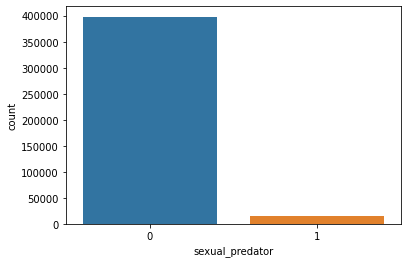

In [57]:
sns.countplot(spi_sub['sexual_predator'])
plt.show()

As we see there is a huge class imbalance. This is expected as in normal cases we would find many more normal users than sexual predators.

In [58]:
spi_sub['sexual_predator'].value_counts()

0    397957
1     14941
Name: sexual_predator, dtype: int64

## Machine Learning model

Splitting the data into train and test sets

In [59]:
# We need to make sure the classes have the same proportion in both sets
X_train, X_test, y_train, y_test = train_test_split(np.array(spi_sub['chat_message'].apply(lambda x: np.str_(x))), 
                                                    np.array(spi_sub['sexual_predator']), stratify = np.array(spi_sub['sexual_predator']),
                                                    test_size = 0.20, random_state = 100)

In [61]:
freq, freq2 = np.unique(y_train, return_counts = True)[1]
freq3, freq4 = np.unique(y_test, return_counts = True)[1]
print(f'The proportion of normal users in training set is {((freq/(freq+ freq2))*100):.2f}% whereas the frequency of sexual predators is {((freq2/(freq+ freq2))*100):.2f}%')
print(f'The proportion of normal users in test set is {((freq3/(freq3+ freq4))*100):.2f}% whereas the frequency of sexual predators is {((freq4/(freq3+ freq4))*100):.2f}%')

The proportion of normal users in training set is 96.38% whereas the frequency of sexual predators is 3.62%
The proportion of normal users in test set is 96.38% whereas the frequency of sexual predators is 3.62%


Extracting tfidf weights

In [63]:
tv = TfidfVectorizer(min_df = 0., max_df = 1., norm = 'l2', use_idf = True, smooth_idf = True)

train_tfidf = tv.fit_transform(X_train)
test_tfidf = tv.transform(X_test)

print(train_tfidf.shape)
print(test_tfidf.shape)

(330318, 93602)
(82580, 93602)


Training the Machine Learning model

1) Logistic Regression Classifier

In [64]:
log_model = LogisticRegression(penalty = 'l2', solver = 'lbfgs', multi_class = 'ovr', max_iter = 1000, C = 1, random_state = 100)
log_model.fit(train_tfidf, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predicting the test set

In [65]:
log_predictions = log_model.predict(test_tfidf)

Classification Report

In [66]:
print(classification_report(y_test, log_predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     79592
           1       0.59      0.08      0.14      2988

    accuracy                           0.96     82580
   macro avg       0.78      0.54      0.56     82580
weighted avg       0.95      0.96      0.95     82580



As expected this model performed very well on the majority class and performed weakly on the minority class. Models like SVM that uses a hyperplane to separate classes would likely yield similar results.

2) Support Vector Machines

In [67]:
svm = LinearSVC(penalty = 'l2', C = 1, random_state = 100)
svm.fit(train_tfidf, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=100, tol=0.0001,
          verbose=0)

In [68]:
svm_predictions = svm.predict(test_tfidf)

In [69]:
print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     79592
           1       0.58      0.10      0.17      2988

    accuracy                           0.96     82580
   macro avg       0.77      0.55      0.58     82580
weighted avg       0.95      0.96      0.95     82580



As expected the SVM model again performs poorly in classifying the minority class.

The class imbalance needs to be handled for a good model. We could either undersample the majority class or oversample the minority class. Within oversampling, we could increase the number of samples by duplicating the observations of the minority class or create synthetic samples similar but not exactly the same. Thus for further work algorithms like SMOTE (Synthetic Minority Oversampling Technique) could be used to create synthetic samples.

We will be using SMOTE for creating synthetic samples

In [72]:
sm = SMOTE(random_state =2)
X_sm, y_sm = sm.fit_sample(train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [73]:
train_tfidf.shape

(330318, 93602)

In [74]:
X_sm.shape

(636730, 93602)

In [75]:
freq, freq2 = np.unique(y_sm, return_counts = True)[1]
print(f'The proportion of normal users in training set is {((freq/(freq+ freq2))*100):.2f}% whereas the frequency of sexual predators is {((freq2/(freq+ freq2))*100):.2f}%')


The proportion of normal users in training set is 50.00% whereas the frequency of sexual predators is 50.00%


In [76]:
log_model = LogisticRegression(penalty = 'l2', solver = 'lbfgs', multi_class = 'ovr', max_iter = 1000, C = 1, random_state = 100)
log_model.fit(X_sm, y_sm)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
log_sm_predictions = log_model.predict(test_tfidf)
print(classification_report(y_test, log_sm_predictions))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     79592
           1       0.18      0.80      0.29      2988

    accuracy                           0.86     82580
   macro avg       0.58      0.83      0.61     82580
weighted avg       0.96      0.86      0.90     82580



That's some improvement in recall. Recall is more important here as it stands for predicting a sexual offender when there is one. This means we 80% of the time we would be able to capture the sexual offender. Though we would want to have a high precision too but this is certainly a huge improvement from the previous results.

In [78]:
svm = LinearSVC(penalty = 'l2', C = 1, random_state = 100)
svm.fit(X_sm, y_sm)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=100, tol=0.0001,
          verbose=0)

In [79]:
svm_sm_predictions = svm.predict(test_tfidf)
print(classification_report(y_test, svm_sm_predictions))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     79592
           1       0.17      0.80      0.28      2988

    accuracy                           0.85     82580
   macro avg       0.58      0.83      0.60     82580
weighted avg       0.96      0.85      0.89     82580



More sophisticated models can be used such as catboost, lstm etc. Also instead of using tfidf we could use word embeddings to get better results. We could also explore more to extract more features and see if we can improve precision and void false positives.